In this we'll implement an L-layered deep neural network and train it on the MNIST dataset. The MNIST dataset contains scanned images of handwritten digits, along with their correct classification labels (between 0-9). MNIST's name comes from the fact that it is a modified subset of two data sets collected by NIST, the United States' National Institute of Standards and Technology.<br>

## Data Preparation

In [1]:
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sklearn
import sklearn.datasets
import scipy
from PIL import Image
from scipy import ndimage


%matplotlib inline

C:\Users\sshukla2\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The MNIST dataset we use here is 'mnist.pkl.gz' which is divided into training, validation and test data. The following function <i> load_data() </i> unpacks the file and extracts the training, validation and test data.

In [2]:
def load_data():
    f = gzip.open('mnist.pkl.gz', 'rb')
    f.seek(0)
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    return (training_data, validation_data, test_data)

Let's see how the data looks:

In [3]:
training_data, validation_data, test_data = load_data()

In [4]:
training_data

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([5, 0, 4, ..., 8, 4, 8], dtype=int64))

In [5]:
# shape of data
print(training_data[0].shape)
print(training_data[1].shape)

(50000, 784)
(50000,)


In [6]:
print("The feature dataset is:" + str(training_data[0]))
print("The target dataset is:" + str(training_data[1]))
print("The number of examples in the training dataset is:" + str(len(training_data[0])))
print("The number of points in a single input is:" + str(len(training_data[0][1])))

The feature dataset is:[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
The target dataset is:[5 0 4 ... 8 4 8]
The number of examples in the training dataset is:50000
The number of points in a single input is:784


Now, as discussed earlier in the lectures, the target variable is converted to a one hot matrix. We use the function <i> one_hot </i> to convert the target dataset to one hot encoding.

In [7]:
def one_hot(j):
    # input is the target dataset of shape (m,) where m is the number of data points
    # returns a 2 dimensional array of shape (10, m) where each target value is converted to a one hot encoding
    # Look at the next block of code for a better understanding of one hot encoding
    n = j.shape[0]
    new_array = np.zeros((10, n))
    index = 0
    for res in j:
        new_array[res][index] = 1.0
        index = index + 1
    return new_array

In [8]:
data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(data.shape)
one_hot(data)

(10,)


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

The following function data_wrapper() will convert the dataset into the desired shape and also convert the ground truth labels to one_hot matrix.

In [9]:
def data_wrapper():
    tr_d, va_d, te_d = load_data()
    
    training_inputs = np.array(tr_d[0][:]).T
    training_results = np.array(tr_d[1][:])
    train_set_y = one_hot(training_results)
    
    validation_inputs = np.array(va_d[0][:]).T
    validation_results = np.array(va_d[1][:])
    validation_set_y = one_hot(validation_results)
    
    test_inputs = np.array(te_d[0][:]).T
    test_results = np.array(te_d[1][:])
    test_set_y = one_hot(test_results)
    
    return (training_inputs, train_set_y, test_inputs, test_set_y)

In [10]:
train_set_x, train_set_y, test_set_x, test_set_y = data_wrapper()

In [11]:
print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x shape: (784, 50000)
train_set_y shape: (10, 50000)
test_set_x shape: (784, 10000)
test_set_y shape: (10, 10000)


We can see that the data_wrapper has converted the training and validation data into numpy array of desired shapes. Let's convert the actual labels into a dataframe to see if the one hot conversions are correct.

In [12]:
y = pd.DataFrame(train_set_y)

In [13]:
print("The target dataset is:" + str(training_data[1]))
print("The one hot encoding dataset is:")
y

The target dataset is:[5 0 4 ... 8 4 8]
The one hot encoding dataset is:


0      1      2      3      4      5      6      7      8      9      \
0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    1.0    0.0    0.0    1.0    0.0    1.0    0.0   
2    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
4    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   
5    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
9    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

   ...    49990  49991  49992  49993  49994  49995  49996  49997  49998  49999  
0  ...      0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0  
1  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2  ...      0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0  
3  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4  ...      0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    1.0    0.0  
5  ...      0.0    1.0    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0  
6  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
7  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
8  ...      1.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    1.0  
9  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[10 rows x 50000 columns]

Now let us visualise the dataset. Feel free to change the index to see if the training data has been correctly tagged.

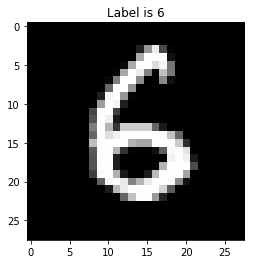

In [14]:
index  = 106
k = train_set_x[:,index]
k = k.reshape((28, 28))
plt.title('Label is {label}'.format(label= training_data[1][index]))
plt.imshow(k, cmap='gray')

# Feedforward

### sigmoid
This is one of the activation functions. It takes the cumulative input to the layer, the matrix **Z**, as the input. Upon application of the **`sigmoid`** function, the output matrix **H** is calculated. Also, **Z** is stored as the variable **sigmoid_memory** since it will be later used in backpropagation.We use _[np.exp()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html)_ here in the following way. The exponential gets applied to all the elements of Z.

In [15]:
def sigmoid(Z):
    
    # Z is numpy array of shape (n, m) where n is number of neurons in the layer and m is the number of samples 
    # sigmoid_memory is stored as it is used later on in backpropagation
    
    H = 1/(1+np.exp(-Z))
    sigmoid_memory = Z
    
    return H, sigmoid_memory

In [16]:
Z = np.arange(8).reshape(4,2)
print ("sigmoid(Z) = " + str(sigmoid(Z)))

sigmoid(Z) = (array([[0.5       , 0.73105858],
       [0.88079708, 0.95257413],
       [0.98201379, 0.99330715],
       [0.99752738, 0.99908895]]), array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]]))


### relu
This is one of the activation functions. It takes the cumulative input to the layer, matrix **Z** as the input. Upon application of the **`relu`** function, matrix **H** which is the output matrix is calculated. Also, **Z** is stored as **relu_memory** which will be later used in backpropagation. We use _[np.maximum()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.maximum.html)_ here in the following way.

In [17]:
def relu(Z):
    # Z is numpy array of shape (n, m) where n is number of neurons in the layer and m is the number of samples 
    # relu_memory is stored as it is used later on in backpropagation
    
    H = np.maximum(0,Z)
    
    assert(H.shape == Z.shape)
    
    relu_memory = Z 
    return H, relu_memory

In [18]:
Z = np.array([1, 3, -1, -4, -5, 7, 9, 18]).reshape(4,2)
print ("relu(Z) = " + str(relu(Z)))

relu(Z) = (array([[ 1,  3],
       [ 0,  0],
       [ 0,  7],
       [ 9, 18]]), array([[ 1,  3],
       [-1, -4],
       [-5,  7],
       [ 9, 18]]))


### softmax
This is the activation of the last layer. It takes the cumulative input to the layer, matrix **Z** as the input. Upon application of the **`softmax`** function, the output matrix **H** is calculated. Also, **Z** is stored as **softmax_memory** which will be later used in backpropagation. We use _[np.exp()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html)_ and _[np.sum()](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.sum.html)_ here in the following way. The exponential gets applied to all the elements of Z.

In [19]:
def softmax(Z):
    # Z is numpy array of shape (n, m) where n is number of neurons in the layer and m is the number of samples 
    # softmax_memory is stored as it is used later on in backpropagation
   
    Z_exp = np.exp(Z)

    Z_sum = np.sum(Z_exp,axis = 0, keepdims = True)
    
    H = Z_exp/Z_sum  #normalising step
    softmax_memory = Z
    
    return H, softmax_memory

In [20]:
Z = np.array([[11,19,10], [12, 21, 23]])

In [21]:
#Z = np.array(np.arange(30)).reshape(10,3)
H, softmax_memory = softmax(Z)
print(H)
print(softmax_memory)

[[2.68941421e-01 1.19202922e-01 2.26032430e-06]
 [7.31058579e-01 8.80797078e-01 9.99997740e-01]]
[[11 19 10]
 [12 21 23]]


### initialize_parameters
Let's now create a function **`initialize_parameters`** which initializes the weights and biases of the various layers. One way to initialise is to set all the parameters to 0. This is not a considered a good strategy as all the neurons will behave the same way and it'll defeat the purpose of deep networks. Hence, we initialize the weights randomly to very small values but not zeros. The biases are initialized to 0. Note that the **`initialize_parameters`** function initializes the parameters for all the layers in one `for` loop. 

The inputs to this function is a list named `dimensions`. The length of the list is the number layers in the network + 1 (the plus one is for the input layer, rest are hidden + output). The first element of this list is the dimensionality or length of the input (784 for the MNIST dataset). The rest of the list contains the number of neurons in the corresponding (hidden and output) layers.

For example `dimensions = [784, 3, 7, 10]` specifies a network for the MNIST dataset with two hidden layers and a 10-dimensional softmax output.

Also, notice that the parameters are returned in a dictionary. This will help in implementing the feedforward through the layer and the backprop throught the layer at once.

In [22]:
def initialize_parameters(dimensions):

    # dimensions is a list containing the number of neuron in each layer in the network
    # It returns parameters which is a python dictionary containing the parameters "W1", "b1", ..., "WL", "bL":

    np.random.seed(2)
    parameters = {}
    L = len(dimensions)            # number of layers in the network + 1

    for l in range(1, L): 
        parameters['W' + str(l)] = np.random.randn(dimensions[l], dimensions[l-1]) * 0.1
        parameters['b' + str(l)] = np.zeros((dimensions[l], 1)) 
        
        assert(parameters['W' + str(l)].shape == (dimensions[l], dimensions[l-1]))
        assert(parameters['b' + str(l)].shape == (dimensions[l], 1))

        
    return parameters

In [23]:
dimensions  = [784, 3,7,10]
parameters = initialize_parameters(dimensions)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
# print("W3 = " + str(parameters["W3"]))
# print("b3 = " + str(parameters["b3"]))

W1 = [[-0.04167578 -0.00562668 -0.21361961 ... -0.06168445  0.03213358
  -0.09464469]
 [-0.05301394 -0.1259207   0.16775441 ... -0.03284246 -0.05623108
   0.01179136]
 [ 0.07386378 -0.15872956  0.01532001 ... -0.08428557  0.10040469
   0.00545832]]
b1 = [[0.]
 [0.]
 [0.]]
W2 = [[ 0.06650944 -0.19626047  0.2112715 ]
 [-0.28074571 -0.13967752  0.02641189]
 [ 0.10925169  0.06646016  0.08565535]
 [-0.11058228  0.03715795  0.13440124]
 [-0.16421272 -0.1153127   0.02013163]
 [ 0.13985659  0.07228733 -0.10717236]
 [-0.05673344 -0.03663499 -0.15460347]]
b2 = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


### layer_forward

The function **`layer_forward`** implements the forward propagation for a certain layer 'l'. It calculates the cumulative input into the layer **Z** and uses it to calculate the output of the layer **H**. It takes **H_prev, W, b and the activation function** as inputs and stores the **linear_memory, activation_memory** in the variable **memory** which will be used later in backpropagation. 

<br> We have to first calculate the **Z**(using the forward propagation equation), **linear_memory**(H_prev, W, b) and then calculate **H, activation_memory**(Z) by applying activation functions - **`sigmoid`**, **`relu`** and **`softmax`** on **Z**.

<br> Note that $$H^{L-1}$$ is referred here as H_prev. We might want to use _[np.dot()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html)_ to carry out the matrix multiplication.

In [24]:
#Graded

def layer_forward(H_prev, W, b, activation = 'relu'):

    # H_prev is of shape (size of previous layer, number of examples)
    # W is weights matrix of shape (size of current layer, size of previous layer)
    # b is bias vector of shape (size of the current layer, 1)
    # activation is the activation to be used for forward propagation : "softmax", "relu", "sigmoid"

    # H is the output of the activation function 
    # memory is a python dictionary containing "linear_memory" and "activation_memory"
    
    if activation == "sigmoid":
        Z = np.dot(W, H_prev) + b # Applying formula Z_l=W_l.H_l-1 +b
        linear_memory = (H_prev, W, b)
        H, activation_memory = sigmoid(Z) # Applying sigmoid  function
 
    elif activation == "softmax":
        Z = np.dot(W, H_prev) + b # Applying formula Z_l=W_l.H_l-1 +b
        linear_memory = (H_prev, W, b)
        H, activation_memory = softmax(Z) # Applying softmax function
    
    elif activation == "relu":
        Z = np.dot(W, H_prev) + b # Applying formula Z_l=W_l.H_l-1 +b
        linear_memory = (H_prev, W, b)
        H, activation_memory = relu(Z)  # Applying softmax function
        
    assert (H.shape == (W.shape[0], H_prev.shape[1]))
    memory = (linear_memory, activation_memory)

    return H, memory

In [25]:
# verify
# l-1 has two neurons, l has three, m = 5
# H_prev is (l-1, m)
# W is (l, l-1)
# b is (l, 1)
# H should be (l, m)
H_prev = np.array([[1,0, 5, 10, 2], [2, 5, 3, 10, 2]])
W_sample = np.array([[10, 5], [2, 0], [1, 0]])
b_sample = np.array([10, 5, 0]).reshape((3, 1))

H = layer_forward(H_prev, W_sample, b_sample, activation="sigmoid")[0]
H

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.99908895, 0.99330715, 0.99999969, 1.        , 0.99987661],
       [0.73105858, 0.5       , 0.99330715, 0.9999546 , 0.88079708]])

We should get:<br>
    array([[1.        , 1.        , 1.        , 1.        , 1.        ],<br>
      [0.99908895, 0.99330715, 0.99999969, 1.        , 0.99987661],<br>
       [0.73105858, 0.5       , 0.99330715, 0.9999546 , 0.88079708]])
    

### L_layer_forward
**`L_layer_forward`** performs one forward pass through the whole network for all the training samples (note that we are feeding all training examples in one single batch). Use the **`layer_forward`** we have created above here to perform the feedforward for layers 1 to 'L-1' in the for loop with the activation **`relu`**. The last layer having a different activation **`softmax`** is calculated outside the loop. Notice that the **memory** is appended to **memories** for all the layers. These will be used in the backward order during backpropagation.

In [26]:
#Graded

def L_layer_forward(X, parameters):

    # X is input data of shape (input size, number of examples)
    # parameters is output of initialize_parameters()
    
    # HL is the last layer's post-activation value
    # memories is the list of memory containing (for a relu activation, for example):
    # - every memory of relu forward (there are L-1 of them, indexed from 1 to L-1), 
    # - the memory of softmax forward (there is one, indexed L) 
    
    memories = []
    H = X
    L = len(parameters) // 2                  # number of layers in the neural network    
    # Implement relu layer (L-1) times as the Lth layer is the softmax layer
    for l in range(1, L):
        H_prev = H        
        # As weights and biases are stored as W1,W2.. and baises as b1,b2.. we need to pick the index of the corresponding
        # weights and biases by concatinating each index with W and b respectively
        W = parameters["W"+str(l)] # like parameter["W1"]       
        b = parameters["b"+str(l)] # like parameter["b1"]
        
        H, memory = layer_forward(H_prev,W,b)
        
        memories.append(memory)
    
    # Implement the final softmax layer
    # HL here is the final prediction P as specified in the lectures
    #For softmax , we have final layer, hence we take the "L" layer to calculate weight and bias
    H_prev = H    
    W = parameters["W"+str(L)]    
    b = parameters["b"+str(L)]    
    #Passing activation function as softmax for the last layer "L"
    HL, memory = layer_forward(H_prev,W,b,"softmax")
    
    memories.append(memory)

    assert(HL.shape == (10, X.shape[1]))
            
    return HL, memories

In [27]:
# verify
# X is (784, 10)
# parameters is a dict
# HL should be (10, 10)
x_sample = train_set_x[:, 10:20]
print(x_sample.shape)
HL = L_layer_forward(x_sample, parameters=parameters)[0]
print(HL[:, :5])

(784, 10)
[[0.10106734 0.10045152 0.09927757 0.10216656 0.1       ]
 [0.10567625 0.10230873 0.10170271 0.11250099 0.1       ]
 [0.09824287 0.0992886  0.09967128 0.09609693 0.1       ]
 [0.10028288 0.10013048 0.09998149 0.10046076 0.1       ]
 [0.09883601 0.09953443 0.09931419 0.097355   0.1       ]
 [0.10668575 0.10270912 0.10180736 0.11483609 0.1       ]
 [0.09832513 0.09932275 0.09954792 0.09627089 0.1       ]
 [0.09747092 0.09896735 0.0995387  0.09447277 0.1       ]
 [0.09489069 0.09788255 0.09929998 0.08915178 0.1       ]
 [0.09852217 0.09940447 0.09985881 0.09668824 0.1       ]]


We should get:

(784, 10)<br>
[[0.10106734 0.10045152 0.09927757 0.10216656 0.1       ]<br>
 [0.10567625 0.10230873 0.10170271 0.11250099 0.1       ]<br>
 [0.09824287 0.0992886  0.09967128 0.09609693 0.1       ]<br>
 [0.10028288 0.10013048 0.09998149 0.10046076 0.1       ]<br>
 [0.09883601 0.09953443 0.09931419 0.097355   0.1       ]<br>
 [0.10668575 0.10270912 0.10180736 0.11483609 0.1       ]<br>
 [0.09832513 0.09932275 0.09954792 0.09627089 0.1       ]<br>
 [0.09747092 0.09896735 0.0995387  0.09447277 0.1       ]<br>
 [0.09489069 0.09788255 0.09929998 0.08915178 0.1       ]<br>
 [0.09852217 0.09940447 0.09985881 0.09668824 0.1       ]]

# Loss

### compute_loss
The next step is to compute the loss function after every forward pass to keep checking whether it is decreasing with training.<br> **`compute_loss`** here calculates the cross-entropy loss. We may want to use _[np.log()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html)_, _[np.sum()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html)_, _[np.multiply()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.multiply.html)_ here. Do not forget that it is the average loss across all the data points in the batch. It takes the output of the last layer **HL** and the ground truth label **Y** as input and returns the **loss**.

In [28]:
#Graded

def compute_loss(HL, Y):


    # HL is probability matrix of shape (10, number of examples)
    # Y is true "label" vector shape (10, number of examples)

    # loss is the cross-entropy loss

    m = Y.shape[1]
    
    # loss is -1.*average of the sum of all the elements of the matrix Ylog(HL) multiplied element-wise.
    loss = -(1./m)* np.sum(np.multiply(Y,np.log(HL))) 
    
    loss = np.squeeze(loss)      # To make sure that the loss's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(loss.shape == ())
    
    return loss

In [29]:
# sample
# HL is (10, 5), Y is (10, 5)
np.random.seed(2)
HL_sample = np.random.rand(10,5)
Y_sample = train_set_y[:, 10:15]
print(HL_sample)
print(Y_sample)

print(compute_loss(HL_sample, Y_sample))

[[0.4359949  0.02592623 0.54966248 0.43532239 0.4203678 ]
 [0.33033482 0.20464863 0.61927097 0.29965467 0.26682728]
 [0.62113383 0.52914209 0.13457995 0.51357812 0.18443987]
 [0.78533515 0.85397529 0.49423684 0.84656149 0.07964548]
 [0.50524609 0.0652865  0.42812233 0.09653092 0.12715997]
 [0.59674531 0.226012   0.10694568 0.22030621 0.34982629]
 [0.46778748 0.20174323 0.64040673 0.48306984 0.50523672]
 [0.38689265 0.79363745 0.58000418 0.1622986  0.70075235]
 [0.96455108 0.50000836 0.88952006 0.34161365 0.56714413]
 [0.42754596 0.43674726 0.77655918 0.53560417 0.95374223]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
0.8964600261334037


We should get:<br>
    
[[0.4359949  0.02592623 0.54966248 0.43532239 0.4203678 ]<br>
 [0.33033482 0.20464863 0.61927097 0.29965467 0.26682728]<br>
 [0.62113383 0.52914209 0.13457995 0.51357812 0.18443987]<br>
 [0.78533515 0.85397529 0.49423684 0.84656149 0.07964548]<br>
 [0.50524609 0.0652865  0.42812233 0.09653092 0.12715997]<br>
 [0.59674531 0.226012   0.10694568 0.22030621 0.34982629]<br>
 [0.46778748 0.20174323 0.64040673 0.48306984 0.50523672]<br>
 [0.38689265 0.79363745 0.58000418 0.1622986  0.70075235]<br>
 [0.96455108 0.50000836 0.88952006 0.34161365 0.56714413]<br>
 [0.42754596 0.43674726 0.77655918 0.53560417 0.95374223]]<br>
[[0. 0. 0. 0. 0.]<br>
 [0. 0. 0. 0. 1.]<br>
 [0. 0. 0. 0. 0.]<br>
 [1. 0. 1. 0. 0.]<br>
 [0. 0. 0. 0. 0.]<br>
 [0. 1. 0. 0. 0.]<br>
 [0. 0. 0. 1. 0.]<br>
 [0. 0. 0. 0. 0.]<br>
 [0. 0. 0. 0. 0.]<br>
 [0. 0. 0. 0. 0.]]<br>
0.8964600261334037

# Backpropagation
Let's now get to the next step - backpropagation. Let's start with sigmoid_backward.

### sigmoid-backward
We might remember that we had created **`sigmoid`** function that calculated the activation for forward propagation. Now, we need the activation backward, which helps in calculating **dZ** from **dH**. Notice that it takes input **dH** and **sigmoid_memory** as input. **sigmoid_memory** is the **Z** which we had calculated during forward propagation. We use _[np.exp()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html)_ here the following way.

In [30]:
def sigmoid_backward(dH, sigmoid_memory):
    
    # Implement the backpropagation of a sigmoid function
    # dH is gradient of the sigmoid activated activation of shape same as H or Z in the same layer    
    # sigmoid_memory is the memory stored in the sigmoid(Z) calculation
    
    Z = sigmoid_memory
    
    H = 1/(1+np.exp(-Z))
    dZ = dH * H * (1-H)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

### relu-backward
We might remember that we had created **`relu`** function that calculated the activation for forward propagation. Now, we need the activation backward, which helps in calculating **dZ** from **dH**. Notice that it takes input **dH** and **relu_memory** as input. **relu_memory** is the **Z** which we calculated uring forward propagation. 

In [31]:
def relu_backward(dH, relu_memory):
    
    # Implement the backpropagation of a relu function
    # dH is gradient of the relu activated activation of shape same as H or Z in the same layer    
    # relu_memory is the memory stored in the sigmoid(Z) calculation
    
    Z = relu_memory
    dZ = np.array(dH, copy=True) # dZ will be the same as dA wherever the elements of A weren't 0
    
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

### layer_backward

**`layer_backward`** is a complimentary function of **`layer_forward`**. Like **`layer_forward`** calculates **H** using **W**, **H_prev** and **b**, **`layer_backward`** uses **dH** to calculate **dW**, **dH_prev** and **db**. We have already studied the formulae in backpropogation. To calculate **dZ**, use the **`sigmoid_backward`** and **`relu_backward`** function. We might need to use _[np.dot()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html)_, _[np.sum()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html)_ for the rest. Remember to choose the axis correctly in db. 

In [32]:
#Graded

def layer_backward(dH, memory, activation = 'relu'):
    
    # takes dH and the memory calculated in layer_forward and activation as input to calculate the dH_prev, dW, db
    # performs the backprop depending upon the activation function
    

    linear_memory, activation_memory = memory
    
    if activation == "relu":
        dZ = relu_backward(dH,activation_memory)
        H_prev, W, b = linear_memory
        m = H_prev.shape[1]
        dW = (1./m)* np.dot(dZ,H_prev.T) # Applying formula (1/m)* dZ_l * transpaose(H_l-1)
        db = (1./m)* np.sum(dZ,axis=1,keepdims=True) # Applying formula (1/m)* dZ_l
        dH_prev = np.dot(W.T,dZ)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dH,activation_memory)
        H_prev, W, b = linear_memory
        m = H_prev.shape[1]
        dW = (1./m)* np.dot(dZ,H_prev.T) # Applying formula (1/m)* dZ_l * transpaose(H_l-1)
        db = (1./m)* np.sum(dZ,axis=1,keepdims=True)  # Applying formula (1/m)* dZ_l
        dH_prev =  np.dot(W.T,dZ)
    
    return dH_prev, dW, db

In [33]:
# verify
# l-1 has two neurons, l has three, m = 5
# H_prev is (l-1, m)
# W is (l, l-1)
# b is (l, 1)
# H should be (l, m)
H_prev = np.array([[1,0, 5, 10, 2], [2, 5, 3, 10, 2]])
W_sample = np.array([[10, 5], [2, 0], [1, 0]])
b_sample = np.array([10, 5, 0]).reshape((3, 1))

H, memory = layer_forward(H_prev, W_sample, b_sample, activation="relu")
np.random.seed(2)
dH = np.random.rand(3,5)
dH_prev, dW, db = layer_backward(dH, memory, activation = 'relu')
print('dH_prev is \n' , dH_prev)
print('dW is \n' ,dW)
print('db is \n', db)

dH_prev is 
 [[5.6417525  0.66855959 6.86974666 5.46611139 4.92177244]
 [2.17997451 0.12963116 2.74831239 2.17661196 2.10183901]]
dW is 
 [[1.67565336 1.56891359]
 [1.39137819 1.4143854 ]
 [1.3597389  1.43013369]]
db is 
 [[0.37345476]
 [0.34414727]
 [0.29074635]]


We should get:<br>
dH_prev is <br>
 [[5.6417525  0.66855959 6.86974666 5.46611139 4.92177244]<br>
 [2.17997451 0.12963116 2.74831239 2.17661196 2.10183901]]<br>
dW is <br>
 [[1.67565336 1.56891359]<br>
 [1.39137819 1.4143854 ]<br>
 [1.3597389  1.43013369]]<br>
db is <br>
 [[0.37345476]<br>
 [0.34414727]<br>
 [0.29074635]]<br>


### L_layer_backward

**`L_layer_backward`** performs backpropagation for the whole network. Recall that the backpropagation for the last layer, i.e. the softmax layer, is different from the rest, hence it is outside the reversed `for` loop. We need to use the function **`layer_backward`** here in the loop with the activation function as **`relu`**. 

In [34]:
#Graded

def L_layer_backward(HL, Y, memories):
    
    # Takes the predicted value HL and the true target value Y and the 
    # memories calculated by L_layer_forward as input
    
    # returns the gradients calulated for all the layers as a dict

    gradients = {}
    L = len(memories) # the number of layers
    m = HL.shape[1]
    Y = Y.reshape(HL.shape) # after this line, Y is the same shape as AL
    
    # Perform the backprop for the last layer that is the softmax layer
    current_memory = memories[-1]
    linear_memory, activation_memory = current_memory
    dZ = HL - Y
    H_prev, W, b = linear_memory
    # Use the expressions we have used in 'layer_backward'
    gradients["dH" + str(L-1)] = np.dot(W.T,dZ)
    gradients["dW" + str(L)] = (1./m)* np.dot(dZ,H_prev.T)
    gradients["db" + str(L)] = (1./m)* np.sum(dZ,axis=1,keepdims=True)
    
    # Perform the backpropagation l-1 times
    for l in reversed(range(L-1)):
        # Lth layer gradients: "gradients["dH" + str(l + 1)] ", gradients["dW" + str(l + 2)] , gradients["db" + str(l + 2)]
        current_memory = memories[l]
        dH=gradients["dH" + str(l+1)]
        dH_prev_temp, dW_temp, db_temp = layer_backward(dH,current_memory)
        gradients["dH" + str(l)] = dH_prev_temp  # assigning the values for the backpropagation
        gradients["dW" + str(l + 1)] = dW_temp
        gradients["db" + str(l + 1)] = db_temp


    return gradients

In [35]:
# verify
# X is (784, 10)
# parameters is a dict
# HL should be (10, 10)
x_sample = train_set_x[:, 10:20]
y_sample = train_set_y[:, 10:20]

HL, memories = L_layer_forward(x_sample, parameters=parameters)
gradients  = L_layer_backward(HL, y_sample, memories)
print('dW3 is \n', gradients['dW3'])
print('db3 is \n', gradients['db3'])
print('dW2 is \n', gradients['dW2'])
print('db2 is \n', gradients['db2'])

dW3 is 
 [[ 0.02003701  0.0019043   0.01011729  0.0145757   0.00146444  0.00059863
   0.        ]
 [ 0.02154547  0.00203519  0.01085648  0.01567075  0.00156469  0.00060533
   0.        ]
 [-0.01718407 -0.00273711 -0.00499101 -0.00912135 -0.00207365  0.00059996
   0.        ]
 [-0.01141498 -0.00158622 -0.00607049 -0.00924709 -0.00119619  0.00060381
   0.        ]
 [ 0.01943173  0.0018421   0.00984543  0.01416368  0.00141676  0.00059682
   0.        ]
 [ 0.01045447  0.00063974  0.00637621  0.00863306  0.00050118  0.00060441
   0.        ]
 [-0.06338911 -0.00747251 -0.0242169  -0.03835708 -0.00581131  0.0006034
   0.        ]
 [ 0.01911373  0.001805    0.00703101  0.0120636   0.00138836 -0.00140535
   0.        ]
 [-0.01801603  0.0017357  -0.01489228 -0.02026076  0.00133528  0.00060264
   0.        ]
 [ 0.0194218   0.00183381  0.00594427  0.01187949  0.00141043 -0.00340965
   0.        ]]
db3 is 
 [[ 0.10031756]
 [ 0.00460183]
 [-0.00142942]
 [-0.0997827 ]
 [ 0.09872663]
 [ 0.00536378]
 [

We should get:<br>

dW3 is <br>
 [[ 0.02003701  0.0019043   0.01011729  0.0145757   0.00146444  0.00059863  0.        ]<br>
 [ 0.02154547  0.00203519  0.01085648  0.01567075  0.00156469  0.00060533   0.        ]<br>
 [-0.01718407 -0.00273711 -0.00499101 -0.00912135 -0.00207365  0.00059996   0.        ]<br>
 [-0.01141498 -0.00158622 -0.00607049 -0.00924709 -0.00119619  0.00060381   0.        ]<br>
 [ 0.01943173  0.0018421   0.00984543  0.01416368  0.00141676  0.00059682   0.        ]<br>
 [ 0.01045447  0.00063974  0.00637621  0.00863306  0.00050118  0.00060441   0.        ]<br>
 [-0.06338911 -0.00747251 -0.0242169  -0.03835708 -0.00581131  0.0006034   0.        ]<br>
 [ 0.01911373  0.001805    0.00703101  0.0120636   0.00138836 -0.00140535   0.        ]<br>
 [-0.01801603  0.0017357  -0.01489228 -0.02026076  0.00133528  0.00060264   0.        ]<br>
 [ 0.0194218   0.00183381  0.00594427  0.01187949  0.00141043 -0.00340965    0.        ]]<br>
db3 is <br>
 [[ 0.10031756]<br>
 [ 0.00460183]<br>
 [-0.00142942]<br>
 [-0.0997827 ]<br>
 [ 0.09872663]<br>
 [ 0.00536378]<br>
 [-0.10124784]<br>
 [-0.00191121]<br>
 [-0.00359044]<br>
 [-0.00104818]]<br>
dW2 is <br>
 [[ 4.94428956e-05  1.13215514e-02  5.44180380e-02]<br>
 [-4.81267081e-05 -2.96999448e-05 -1.81899582e-02]<br>
 [ 5.63424333e-05  4.77190073e-03  4.04810232e-02]<br>
 [ 1.49767478e-04 -1.89780927e-03 -7.91231369e-03]<br>
 [ 1.97866094e-04  1.22107085e-04  2.64140566e-02]<br>
 [ 0.00000000e+00 -3.75805770e-04  1.63906102e-05]<br>
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]<br>
db2 is <br>
 [[ 0.013979  ]<br>
 [-0.01329383]<br>
 [ 0.01275707]<br>
 [-0.01052957]<br>
 [ 0.03179224]<br>
 [-0.00039877]<br>
 [ 0.        ]]<br>

# Parameter Updates

Now that we have calculated the gradients. let's do the last step which is updating the weights and biases.

In [36]:
#Graded

def update_parameters(parameters, gradients, learning_rate):

    # parameters is the python dictionary containing the parameters W and b for all the layers
    # gradients is the python dictionary containing your gradients, output of L_model_backward
    
    # returns updated weights after applying the gradient descent update

    
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        #Assigning the corresponding parameters
        W=parameters["W"+str(l+1)]
        b=parameters["b"+str(l+1)]
        dW=gradients["dW"+str(l+1)]
        db=gradients["db"+str(l+1)]
        
        #Updating the paramaetrs
        parameters["W" + str(l+1)] = W - (learning_rate * dW)
        parameters["b" + str(l+1)] = b - (learning_rate *db)

        
    return parameters

Having defined the bits and pieces of the feedforward and the backpropagation, let's now combine all that to form a model. The list `dimensions` has the number of neurons in each layer specified in it. For a neural network with 1 hidden layer with 45 neurons, we would specify the dimensions as follows:

In [37]:
dimensions = [784, 45, 10] #  three-layer model

# Model

### L_layer_model

This is a composite function which takes the training data as input **X**, ground truth label **Y**, the **dimensions** as stated above, **learning_rate**, the number of iterations **num_iterations** and if we want to print the loss, **print_loss**. We need to use the final functions we have written for feedforward, computing the loss, backpropagation and updating the parameters.

In [38]:
#Graded

def L_layer_model(X, Y, dimensions, learning_rate = 0.0075, num_iterations = 3000, print_loss=False):
    
    # X and Y are the input training datasets
    # learning_rate, num_iterations are gradient descent optimization parameters
    # returns updated parameters

    np.random.seed(2)
    losses = []                         # keep track of loss
    
    # Parameters initialization
    parameters = initialize_parameters(dimensions)
 
    for i in range(0, num_iterations):

        # Forward propagation
        HL, memories = L_layer_forward(X,parameters)
        
        # Compute loss
        loss = compute_loss(HL,Y)
    
        # Backward propagation
        gradients = L_layer_backward(HL,Y,memories)
 
        # Update parameters.
        parameters = update_parameters(parameters, gradients, learning_rate)
                
        # Printing the loss every 100 training example
        if print_loss and i % 100 == 0:
            print ("Loss after iteration %i: %f" %(i, loss))
            losses.append(loss)
            
    # plotting the loss
    plt.plot(np.squeeze(losses))
    plt.ylabel('loss')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Since, it'll take a lot of time to train the model on 50,000 data points, we take a subset of 5,000 images.

In [39]:
train_set_x_new = train_set_x[:,0:5000]
train_set_y_new = train_set_y[:,0:5000]
train_set_x_new.shape

(784, 5000)

Now, let's call the function L_layer_model on the dataset we have created.This will take 10-20 mins to run.

Loss after iteration 0: 2.422624
Loss after iteration 100: 2.129232
Loss after iteration 200: 1.876095
Loss after iteration 300: 1.604213
Loss after iteration 400: 1.350205
Loss after iteration 500: 1.144823
Loss after iteration 600: 0.990554
Loss after iteration 700: 0.876603
Loss after iteration 800: 0.791154
Loss after iteration 900: 0.725441
Loss after iteration 1000: 0.673485
Loss after iteration 1100: 0.631386
Loss after iteration 1200: 0.596598
Loss after iteration 1300: 0.567342
Loss after iteration 1400: 0.542346
Loss after iteration 1500: 0.520746
Loss after iteration 1600: 0.501865
Loss after iteration 1700: 0.485205
Loss after iteration 1800: 0.470368
Loss after iteration 1900: 0.457054


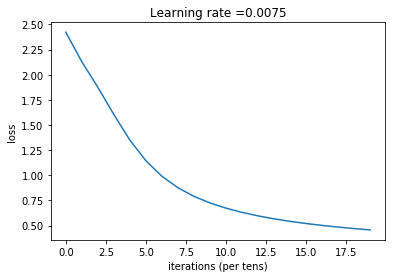

In [40]:
parameters = L_layer_model(train_set_x_new, train_set_y_new, dimensions, num_iterations = 2000, print_loss = True)

In [41]:
def predict(X, y, parameters):
    
    # Performs forward propogation using the trained parameters and calculates the accuracy
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    
    # Forward propagation
    probas, caches = L_layer_forward(X, parameters)
    
    p = np.argmax(probas, axis = 0)
    act = np.argmax(y, axis = 0)

    print("Accuracy: "  + str(np.sum((p == act)/m)))
        
    return p

Let's see the accuray we get on the training data.

In [42]:
pred_train = predict(train_set_x_new, train_set_y_new, parameters)

Accuracy: 0.8774000000000002


We get ~ 88% accuracy on the training data. Let's see the accuray on the test data.

In [43]:
pred_test = predict(test_set_x, test_set_y, parameters)

Accuracy: 0.8674000000000002


It is ~87%. We can train the model even longer and get better result. We can also try to change the network structure. 
<br>Below, we can see which all numbers are incorrectly identified by the neural network by changing the index.

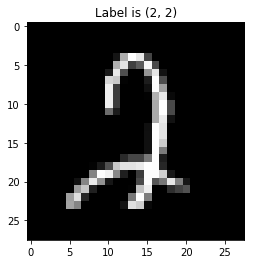

In [44]:
index  = 3474
k = test_set_x[:,index]
k = k.reshape((28, 28))
plt.title('Label is {label}'.format(label=(pred_test[index], np.argmax(test_set_y, axis = 0)[index])))
plt.imshow(k, cmap='gray')

### With iterations = 3000

Loss after iteration 0: 2.422624
Loss after iteration 100: 2.129232
Loss after iteration 200: 1.876095
Loss after iteration 300: 1.604213
Loss after iteration 400: 1.350205
Loss after iteration 500: 1.144823
Loss after iteration 600: 0.990554
Loss after iteration 700: 0.876603
Loss after iteration 800: 0.791154
Loss after iteration 900: 0.725441
Loss after iteration 1000: 0.673485
Loss after iteration 1100: 0.631386
Loss after iteration 1200: 0.596598
Loss after iteration 1300: 0.567342
Loss after iteration 1400: 0.542346
Loss after iteration 1500: 0.520746
Loss after iteration 1600: 0.501865
Loss after iteration 1700: 0.485205
Loss after iteration 1800: 0.470368
Loss after iteration 1900: 0.457054
Loss after iteration 2000: 0.445034
Loss after iteration 2100: 0.434120
Loss after iteration 2200: 0.424141
Loss after iteration 2300: 0.414967
Loss after iteration 2400: 0.406498
Loss after iteration 2500: 0.398653
Loss after iteration 2600: 0.391355
Loss after iteration 2700: 0.384535
Loss

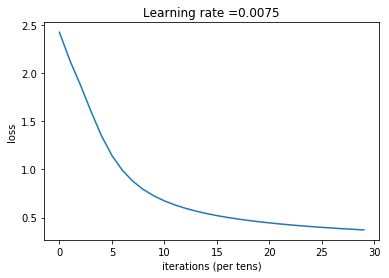

In [45]:
parameters = L_layer_model(train_set_x_new, train_set_y_new, dimensions, num_iterations = 3000, print_loss = True)

In [46]:
pred_train = predict(train_set_x_new, train_set_y_new, parameters)

Accuracy: 0.8982000000000002


In [47]:
pred_test = predict(test_set_x, test_set_y, parameters)

Accuracy: 0.8822000000000003


### The accuracy has improved with increasing the iterations

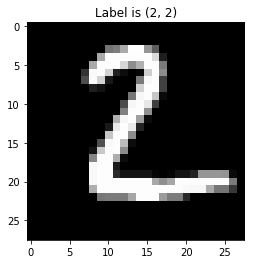

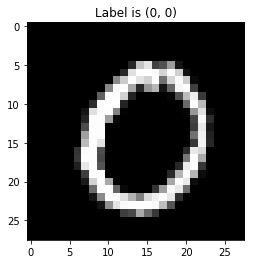

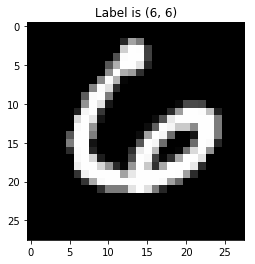

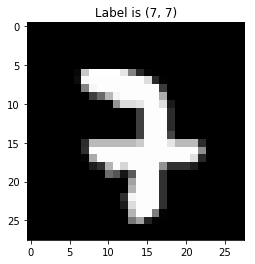

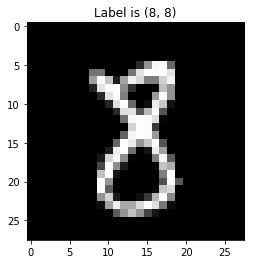

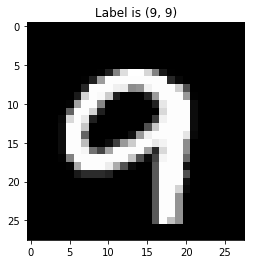

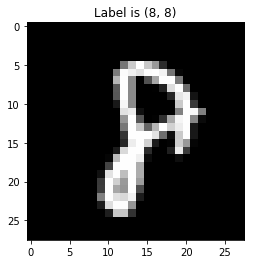

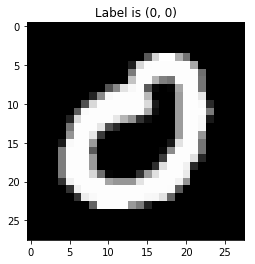

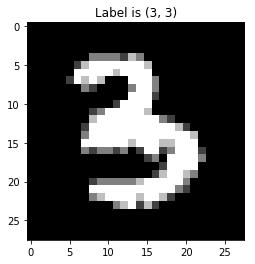

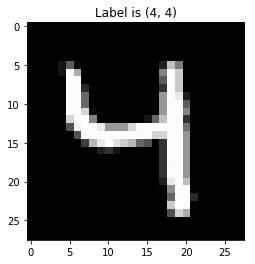

In [48]:
for index in range(1,1000,100):    
    k = test_set_x[:,index]
    k = k.reshape((28, 28))    
    plt.title('Label is {label}'.format(label=(pred_test[index], np.argmax(test_set_y, axis = 0)[index])))
    plt.imshow(k, cmap='gray')
    plt.show()

### With iterations = 4000

Loss after iteration 0: 2.422624
Loss after iteration 100: 2.129232
Loss after iteration 200: 1.876095
Loss after iteration 300: 1.604213
Loss after iteration 400: 1.350205
Loss after iteration 500: 1.144823
Loss after iteration 600: 0.990554
Loss after iteration 700: 0.876603
Loss after iteration 800: 0.791154
Loss after iteration 900: 0.725441
Loss after iteration 1000: 0.673485
Loss after iteration 1100: 0.631386
Loss after iteration 1200: 0.596598
Loss after iteration 1300: 0.567342
Loss after iteration 1400: 0.542346
Loss after iteration 1500: 0.520746
Loss after iteration 1600: 0.501865
Loss after iteration 1700: 0.485205
Loss after iteration 1800: 0.470368
Loss after iteration 1900: 0.457054
Loss after iteration 2000: 0.445034
Loss after iteration 2100: 0.434120
Loss after iteration 2200: 0.424141
Loss after iteration 2300: 0.414967
Loss after iteration 2400: 0.406498
Loss after iteration 2500: 0.398653
Loss after iteration 2600: 0.391355
Loss after iteration 2700: 0.384535
Loss

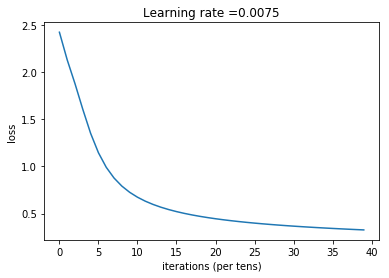

In [49]:
parameters = L_layer_model(train_set_x_new, train_set_y_new, dimensions, num_iterations = 4000, print_loss = True)

In [50]:
pred_train = predict(train_set_x_new, train_set_y_new, parameters)

Accuracy: 0.9094000000000002


In [51]:
pred_test = predict(test_set_x, test_set_y, parameters)

Accuracy: 0.8886000000000003


### The accuracy has further improved with increasing the iterations=4000

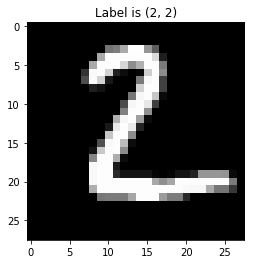

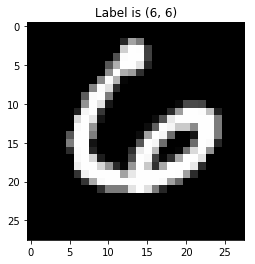

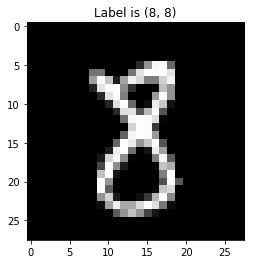

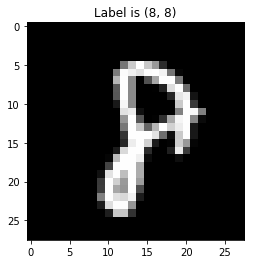

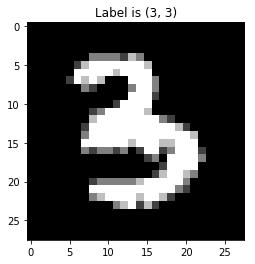

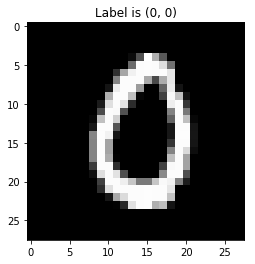

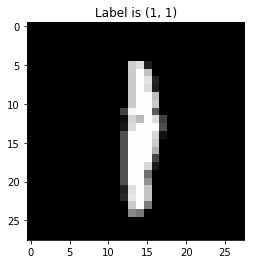

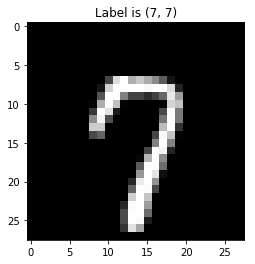

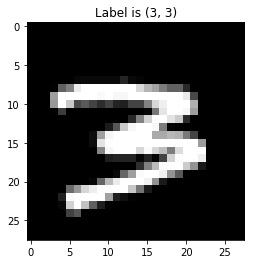

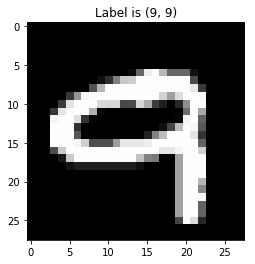

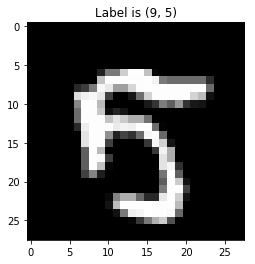

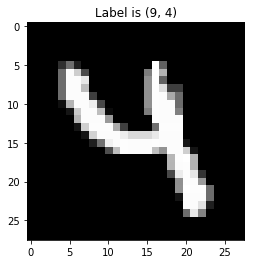

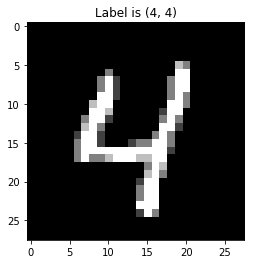

In [52]:
for index in range(1,2500,200):     
    k = test_set_x[:,index]
    k = k.reshape((28, 28))
    plt.title('Label is {label}'.format(label=(pred_test[index], np.argmax(test_set_y, axis = 0)[index])))
    plt.imshow(k, cmap='gray')
    plt.show()